In [0]:
#!pip install pytorch-tabnet -q
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
#from pytorch_tabnet.tab_model import TabNetClassifier
import seaborn as sns

def seed_everything(seed):
    random.seed(seed)
    #os.environ['NEPTUNE_API_TOKEN'] = NEPTUNE_API_TOKEN
    np.random.seed(seed)

seed_everything(43)

DATA_DIR = '/content/data/'

In [0]:
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')

In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33126 non-null  object 
 3   age_approx                     33126 non-null  float64
 4   anatom_site_general_challenge  33126 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [0]:
df_train['sex'].value_counts()

male      17080
female    15981
Name: sex, dtype: int64

In [0]:
df_train['diagnosis'].value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
Name: diagnosis, dtype: int64

In [0]:
df_train['anatom_site_general_challenge'].value_counts()

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64

In [0]:
df_train['age_approx'].describe()

count    33126.000000
mean        48.872336
std         14.365684
min          0.000000
25%         40.000000
50%         50.000000
75%         60.000000
max         90.000000
Name: age_approx, dtype: float64

In [0]:
df_train['age_approx'] = df_train['age_approx'].fillna(50)
df_train['anatom_site_general_challenge'] = df_train['anatom_site_general_challenge'].fillna('torso')
df_train['sex'] = df_train['sex'].fillna('male')

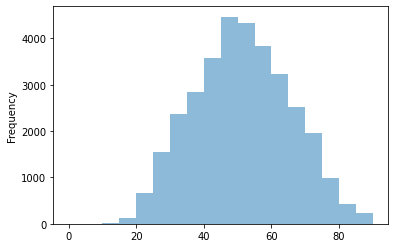

In [0]:
df_train['age_approx'].plot.hist(bins=18, alpha=0.5)

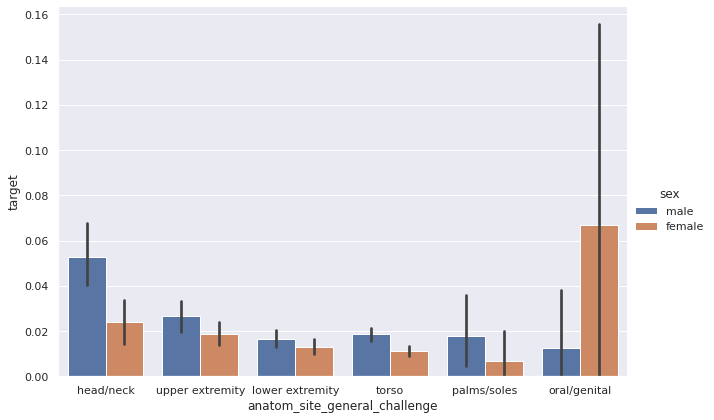

In [0]:
sns.catplot(
    x="anatom_site_general_challenge", 
    y="target", hue="sex", kind="bar", 
    height=6, aspect=1.5, data=df_train
);

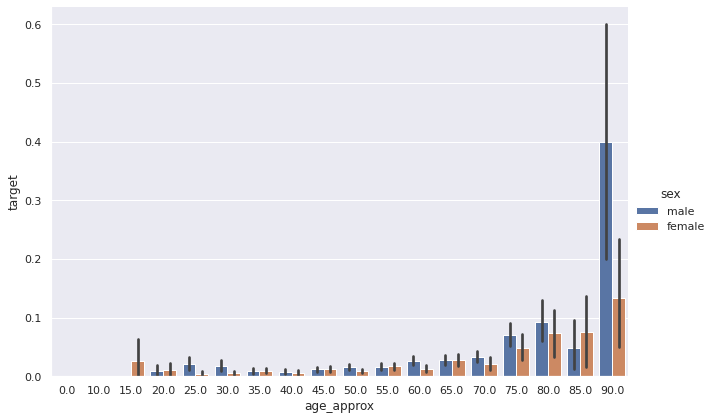

In [0]:
sns.catplot(
    x="age_approx", 
    y="target", hue="sex", kind="bar", 
    height=6, aspect=1.5, data=df_train
);

In [0]:
target = 'target'
X_train, X_val, y_train, y_val = train_test_split(
    df_train, df_train[target], 
    test_size=0.3, random_state=43,
    stratify=df_train[target],
)
train_indices = X_train.index
valid_indices = X_val.index

nunique = df_train.nunique()
types = df_train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in df_train.columns:
    if types[col] == 'object' or nunique[col] < 20:
        print(col, df_train[col].nunique())
        l_enc = LabelEncoder()
        fillna_val = df_train[col].value_counts().index[0]
        df_train[col] = df_train[col].fillna(fillna_val)
        df_train[col] = l_enc.fit_transform(df_train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        df_train.fillna(df_train.loc[train_indices, col].mean(), inplace=True)

unused_feat = ['patient_id', 'image_name', 'diagnosis', 'benign_malignant']

features = [ col for col in df_train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

image_name 33126
patient_id 2056
sex 2
age_approx 18
anatom_site_general_challenge 6
diagnosis 9
benign_malignant 2
target 2


In [0]:
X_train = df_train[features].values[train_indices]
y_train = df_train[target].values[train_indices]
X_val = df_train[features].values[valid_indices]
y_val = df_train[target].values[valid_indices]

In [0]:
X_train = np.concatenate((X_train,cnn_pred_train[..., np.newaxis]),axis=1)
X_val = np.concatenate((X_val,cnn_pred_val[..., np.newaxis]),axis=1)

In [0]:
clf = XGBClassifier(n_estimators=500, n_jobs=4, seed=43)
clf.fit(X_train, y_train, eval_metric=roc_auc_score)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=43,
              silent=None, subsample=1, verbosity=1)

auc score:  0.8293454880671924


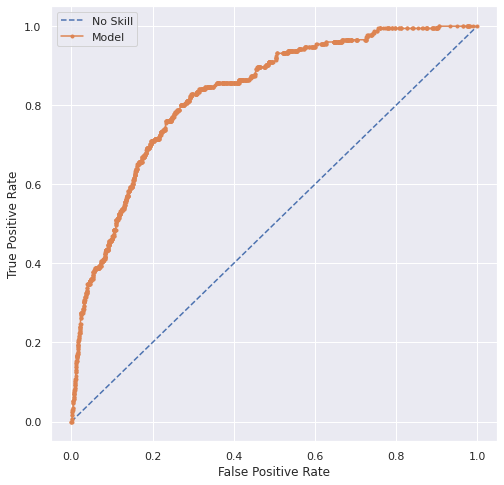

'/content/logs/roc_curve_01-06-2020-10H-19M.png'

In [0]:
y_pred = clf.predict_proba(X_val)
print('auc score: ', roc_auc_score(y_val, y_pred[:,1]))
plot_roc(y_val, y_pred[:,1], True)

In [0]:
val = pd.DataFrame(columns=['y_val', 'y_pred', 'diff'])
val['y_pred'] = y_pred[:,1]
val['y_val'] = y_val
val['diff'] = val['y_val'] - val['y_pred']
val.describe()

,y_val,y_pred,diff
count,9938.000000,9938.000000,9938.000000
mean,0.017609,0.013810,0.003799
std,0.131533,0.065985,0.136376
min,0.000000,0.000010,-0.944005
25%,0.000000,0.000033,-0.000446
50%,0.000000,0.000094,-0.000091
75%,0.000000,0.000556,-0.000031
max,1.000000,0.944005,0.999982
